In [1]:
from simple_vit import SimpleViT
import matplotlib.pyplot as plt
from vit import ViT

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='../data_mnist_train',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.FashionMNIST(
    root='../data_mnist_test',
    train=False,
    download=True,
    transform=transform_train
)

In [3]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=10
)

In [4]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
num_classes = len(class_names)

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

In [6]:
def show_images_with_labels(images, labels):
    fig = plt.figure(figsize=(10, 4))
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[idx].item()])
    plt.show()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


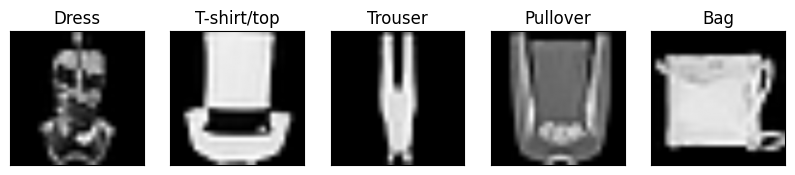

In [7]:
show_images_with_labels(images, labels)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ViT(image_size=224, patch_size=16, num_classes=num_classes, dim=1024, depth=6, heads=16, mlp_dim=2048).to(device)
model = SimpleViT(image_size=224, patch_size=16, num_classes=num_classes, dim=128, depth=6, heads=16, mlp_dim=2048).to(device)

lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=lr
)

total_epochs = 10
best_acc = 0.0
loss_history = [[] for x in range(total_epochs)]
loss_history_test = [[] for x in range(total_epochs)]
history = []
# history = [{} for x in range(total_epochs)]

for epoch in range(total_epochs):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0
    val_loss = 0.0
    total_train = 0
    correct_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}", leave=False)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)

        # 32, 3, 224, 224
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_train += images.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history[epoch].append(loss.item())
        train_loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_loss = criterion(outputs, labels)
            loss_history_test[epoch].append(test_loss.item())
            val_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    train_acc = 100 * correct_train / total_train

    epoch_time = time.time() - epoch_start
    history.append(
        {
            'loss': running_loss / len(train_loader),
            'val_loss': val_loss / len(train_loader),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
        }
    )
    print(
        f"Epoch [{epoch + 1}/{total_epochs}] | "
        f"Loss: {running_loss / len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {epoch_time:.2f}s"
    )

KeyboardInterrupt: 

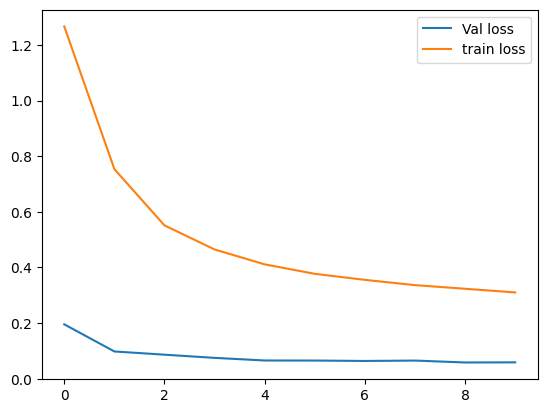

In [9]:
val_loss_ = [history[x]['val_loss'] for x in range(total_epochs)]
train_loss_ = [history[x]['loss'] for x in range(total_epochs)]

plt.figure()
plt.plot(val_loss_, label='Val loss')
plt.plot(train_loss_, label='train loss')
plt.legend()

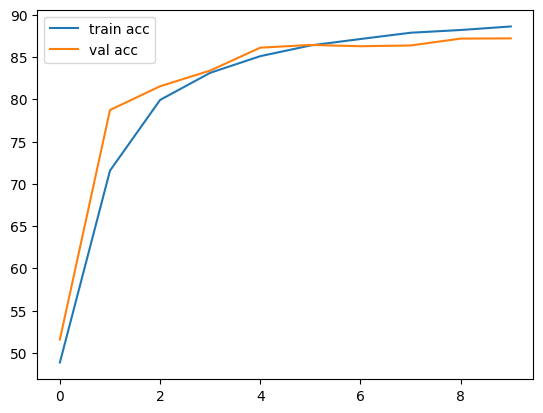

In [10]:
train_acc_ = [history[x]['train_acc'] for x in range(total_epochs)]
val_acc_ = [history[x]['val_acc'] for x in range(total_epochs)]

plt.figure()
plt.plot(train_acc_, label='train acc')
plt.plot(val_acc_, label='val acc')
plt.legend()

In [11]:
test_iter = iter(test_loader)

In [12]:
img, label = next(test_iter)
img, label = img.to(device), label.to(device)

result = model(img)

In [13]:
_, predicted = torch.max(result.data, 1)
print(predicted)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 7, 7, 9,
        1, 6, 6, 0, 9, 4, 8, 8], device='cuda:0')


In [14]:
def show_images_with_labels_predicted(images, labels, result):
    fig = plt.figure(figsize=(18, 6))
    _, predicted = torch.max(result.data, 1)
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(f"T: {class_names[labels[idx].item()]}, P: {class_names[predicted[idx].item()]}")
    plt.show()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


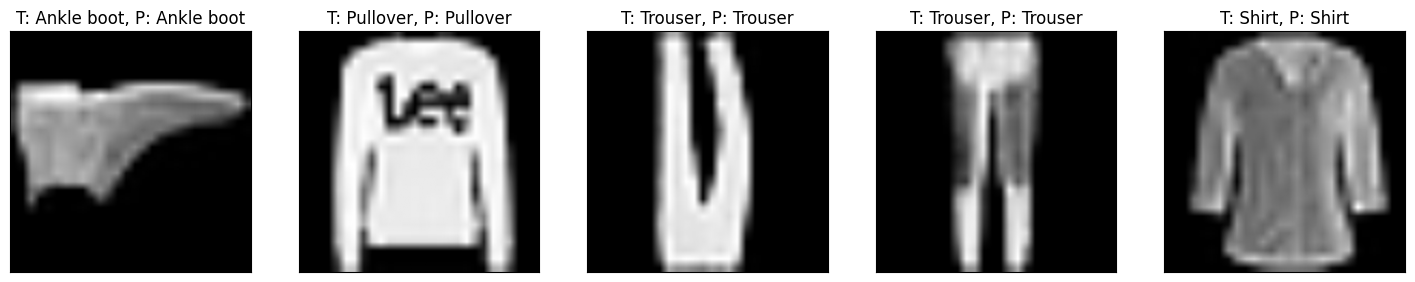

In [15]:
show_images_with_labels_predicted(img.to('cpu'), label.to('cpu'), result.to('cpu'))

In [16]:
from datetime import datetime

now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H:%M:%S")

In [17]:
def list_to_dictionary(data):
    keys_ = data[0].keys()
    length_ = len(data)

    temp_ = {}
    for key_ in keys_:
        temp_[key_] = []
        for i in range(length_):
            temp_[key_].append(data[i][key_])

    return temp_

In [18]:
temp = list_to_dictionary(history)

In [19]:
from pathlib import Path
name = "VT_simple_"+timestamp+".pth"
path_1 = "./weights/"
path_2 = path_1 + name
Path(path_1).mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), path_2)

In [20]:
path = "./results/VT_simple_"+timestamp
Path(path).mkdir(parents=True, exist_ok=True)

In [21]:
import pickle

with open(path + "/history.pickle", 'wb') as f:
    pickle.dump(history, f)

with open(path + "/loss_history.pickle", 'wb') as f:
    pickle.dump(loss_history, f)

with open(path + "/loss_history_test.pickle", 'wb') as f:
    pickle.dump(loss_history_test, f)